In [1]:
import torch
import numpy as np
import imutils
import time
import random
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

import matplotlib.pyplot as plt
import torch.nn as nn

import models.MathNet as mnt
import models.MathNet112 as mnt112
from utils.letter import Letter
from utils.printer import PrettyPrinter

In [2]:
MODEL_PATH = 'models\mathnet224\mathnet8.ml'
printer = PrettyPrinter()

In [3]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
IMAGE_NAME = 'T:\my_programs\Math_recognition\TEST\\real1.jpg'
image = cv2.imread(IMAGE_NAME)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imshow("tt", thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [5]:
def add_border(image):
        pad = 10
        mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
        mask2 = np.pad(mask1, pad_width=pad)
        print(image.shape, mask1.shape, mask2.shape)
        res = cv2.bitwise_and(mask2, image)
        res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
        return res

In [6]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [7]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [8]:
class ContoursDetector():
    def __init__(self, model, kwargs):
        self.model = model
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.model.eval()
        self.kwargs = kwargs
        self.average_size = (1, 1)

    
    def preprocess(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(gray, (3, 3))
        thresh_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,20)
        thresh_img = add_border(thresh_img)
        kernel = np.ones((1, 1), np.uint8)
        opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        img_erode = cv2.erode(closing, np.ones((3, 3), np.uint8), iterations=4)
        
        if self.kwargs['VISUALIZE'] == True:
            cv2.imshow('preprocess', img_erode)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        return img_erode

    def get_rois(self, image, orig):
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(orig, (3, 3))
        image = add_border(image)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
        img_contours = np.uint8(np.ones((image.shape[0],image.shape[1])))
        # Filter contours
        mask = np.uint8(np.ones((image.shape[0],image.shape[1])) * 255.)
        contours = contours[1:]
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            crop_orig = blurred[y:y+h, x:x+w]
            thresh_img = cv2.adaptiveThreshold(crop_orig, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,31,8)
            black_count = w*h - cv2.countNonZero(thresh_img)
            if black_count > 10:
                mask[y:y+h, x:x+w] = thresh_img
            else:
                pass
        if self.kwargs['VISUALIZE'] == True:
            cv2.imshow('preprocess', mask)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        mask = cv2.bitwise_not(mask)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        letters = []
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            if hierarchy[0][idx][3] != -1 or cv2.contourArea(contour) < 15:
                continue
            #_, blurred = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            crop_img = orig[y:y+h, x:x+w]
            letter = Letter(x,y,w,h,crop_img)
            letters.append(letter)
        return letters

    def visualize_rois(self, img, rois):
        output = Image.fromarray(img.astype('uint8'))        
        res_letters = []
        for idx in range(0, len(rois)):
            roi = rois[idx]
            res_letters.append(roi)
            draw = ImageDraw.Draw(output)
            draw.rectangle((roi.x, roi.y, roi.right, roi.bottom), outline=(255,0,0))
        output.show()
        return (output, res_letters)
        
    def visualize_preds(self, img, letters, hlines):
        #output = Image.new("RGBA", img.size)
        output = Image.fromarray(img.astype('uint8'))
        output = output.convert('RGB')
        font = ImageFont.truetype("T:\my_programs\Math_recognition\\resources\ARIALUNI.TTF", 10, encoding="unic")
        draw = ImageDraw.Draw(output)
        res_letters = []
        for letter in letters:
            res_letters.append(letter)
            draw.rectangle((letter.x, letter.y, letter.x+letter.width, letter.y+letter.height), outline=(0,255,0))
            #draw.text((letter.x, letter.y), "{}; {:.3f}.".format(mnt.map_pred(letter.value), letter.score), font=font, fill=(200,40,0,255))
        for hline in hlines:
            draw.rectangle((hline.x, hline.y, hline.right, hline.bottom), outline=(215,56,0))
        display(output)
        return (output, res_letters)

    def get_exact_locations(self, rois):
        res = []
        (avg_w, avg_h) = average_size(rois)
        self.average_size = (avg_w, avg_h)
        for letter in rois:
            #remove small noise
            # if letter.w < avg_w / 2 and letter.height - avg_h / 2 < 0:
            #     #print(letter.w)
            #     continue
            #find horizontal lines
            if (letter.w > avg_w * 1.75):
                letter.value = '_hline'
            _, thresh_img = cv2.threshold(letter.image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            letter.image = thresh_img
            res.append(letter)
        print(self.average_size)
        return res
    
    def predict(self, letters):
        regions_of_interest = []
        labels = {}
        hlines = []
        torch.cuda.empty_cache()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        for letter in letters:
            if (letter.value[0] == '_'):
                if (letter.value == "_hline"):
                    letter.score = 100
                    hlines.append(letter)
                    continue
                #letter.value = '_line'
            letter.add_frame()            
            img = Image.fromarray(letter.image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize(self.kwargs['INPUT_SIZE']),
                transforms.Grayscale(1),
                transforms.GaussianBlur(3),
                # transforms.ToTensor()
            ])
            x_image = convert_tensor(img)
            x_image = add_contrast(x_image, 5)
            #display(x_image)
            to_tensor = transforms.ToTensor()

            x_tensor = to_tensor(x_image)
            
            x_tensor = x_tensor.unsqueeze(0).float()
            x_tensor = x_tensor.to(device)

            predicted = self.model(x_tensor)
            prob = predicted.max().item()
           
            if prob >= self.kwargs['MIN_CONF']:
                letter.value = predicted.argmax().item()
                letter.score = prob
                ll = labels.get(letter.value, [])
                ll.append(letter)
                labels[letter.value] = ll
                regions_of_interest.append(letter)
                #print(letter.value, prob, printer.char(letter.value))
            else:
                print(prob, mnt.map_pred(predicted.argmax().item()))
                display(x_image)
        return (regions_of_interest, labels, hlines)
    

    def __call__(self, img):
        processed_image = self.preprocess(img)
        regions_of_interest = self.get_rois(processed_image, img)

        if self.kwargs['DEBUG'] == True:
            print('regions_of_interest = ', len(regions_of_interest))
            self.visualize_rois(img, regions_of_interest)

        regions_of_interest = self.get_exact_locations(regions_of_interest)
        #self.add_spaces_to_letter(regions_of_interest)

        (regions_of_interest, preds, hlines) = self.predict(regions_of_interest)
        hlines.sort(key=lambda ll: (ll.y), reverse=False)
        if self.kwargs['DEBUG'] == True:
            print('letters predicted = ', len(regions_of_interest))
            print('hlines predicted = ', len(hlines))

        if self.kwargs['DEBUG'] == True:
            print('found letters = ', len(regions_of_interest))
        (_, letters) = self.visualize_preds(img, regions_of_interest, hlines)
        printer = PrettyPrinter()
        printer.print(letters)
        return (_, letters, hlines)

(780, 1070) (760, 1050) (780, 1070)
(780, 1070) (760, 1050) (780, 1070)
regions_of_interest =  36
(42.75, 47.25)
letters predicted =  35
hlines predicted =  1
found letters =  35


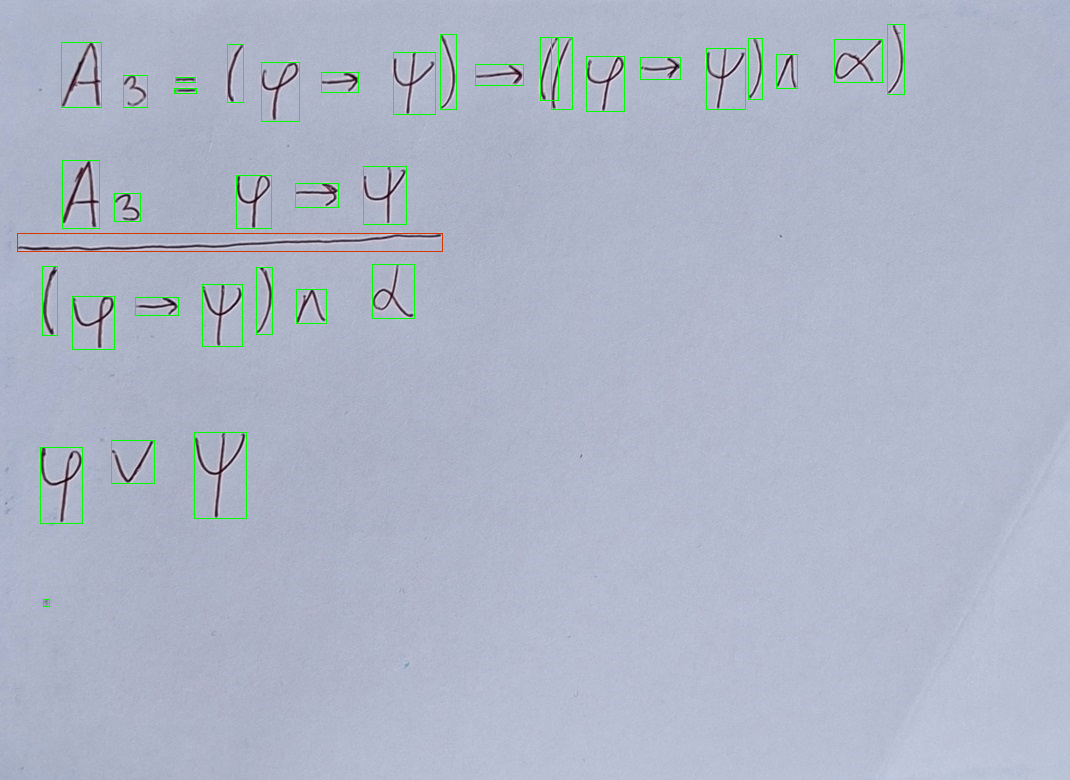

 
+ ∃ - ( φ → ψ ) → ( y φ → ψ ) λ α ) 
- 
+ ∃ φ → y 
( φ → ψ ) λ α 
φ υ ψ 
8


107

In [9]:
path = 'T:\my_programs\Math_recognition\TEST\\real1.jpg'
kwargs = dict(
        INPUT_SIZE=(224, 224),
        VISUALIZE=True,
        MIN_CONF=0.05,
        DEBUG=True
    )
image = cv2.imread(path)

# def horizontal_blur_kernel(kernel_size):
#     kernel = np.zeros((kernel_size, kernel_size))
#     middle = kernel_size // 2
#     for i in range(middle):
#         kernel[middle][i] = 1/kernel_size
#         kernel[middle][kernel_size-1-i] = 1/kernel_size
#     return kernel
# kernel = horizontal_blur_kernel(12)
# image = cv2.filter2D(image, -1, kernel=kernel)

# cv2.imshow("a", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
sw = ContoursDetector(model, kwargs)
res = sw(image)
(_, letters, hlines) = res
res[1][0].bottom
# for item in letters:
#     print(item.line, printer.char(item.value))


33


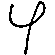

In [10]:
first = res[1][11]
let_image = Image.fromarray(first.image.astype('uint8'))
print(first.value)
display(let_image)

In [11]:
operations = ['(', ')', 
              '-', '+', 
              'and', 'or', 'not', 'rightarrow', 
              '=', 'equals', 'I-',
              'exists','forall',]
greek = ['alpha','beta','delta','gamma','lambda','mu','omega','phi',
 'pi','psi','sigma','tau','theta','upsilon']
latin = ['A', 'C', 'F', 'x', 'y', 'z']
latin_variables = ['x', 'y', 'z']


In [12]:
class Node:
    def __init__(self, value) -> None:
        self.value = value
        #self.letters.sort(key=lambda ll: (ll.x), reverse=False)
        self.x = 0#letters[0].x
        self.y = 0#min(map(lambda x: x.y, self.letters))
        self.r = 0#max(map(lambda x: x.right, self.letters))
        self.b = 0#max(map(lambda x: x.bottom, self.letters))
        self.left = None
        self.right = None
        self.parent = None
        self.printer = PrettyPrinter()

    def print(self):
        res = ''
        if self.left is not None:
            for letter in self.left.value.letters:
                res += printer.pretty(letter.value) + ' '
            res += ';'
            if self.right is not None:
                for letter in self.right.value.letters:
                    res += printer.pretty(letter.value) + ' '
            res +='\n'
            for i in range(0, 12):
                res += '--'
            res +='\n'
        for letter in self.value.letters:
            res += printer.pretty(letter.value) + ' '
        print(res)

    def init(self, hline, letters):
        self.letters.sort(key=lambda ll: (ll.x), reverse=False)
        self.x = letters[0].x
        self.y = min(map(lambda x: x.y, self.letters))
        self.right = max(map(lambda x: x.right, self.letters))
        self.bottom = max(map(lambda x: x.bottom, self.letters))
    
class Group:
    def __init__(self, value) -> None:
        self.letters = value
        self.letters.sort(key=lambda ll: (ll.x), reverse=False)
        self.left = self.letters[0].left
        self.right = self.letters[-1].right
        self.top = min(map(lambda x: x.y, self.letters))
        self.bottom = max(map(lambda x: x.bottom, self.letters))
        self.line = self.letters[0].line

    def print(self):
        res = ''
        for item in self.letters:
            res += printer.pretty(item.value) + ' '
        print(res)


In [13]:
# hlines = res[2]
# _letters = letters
# token_groups = []
# for line in hlines:
#     node = Node(line)
#     up = []
#     down = []
#     #rint(line.top)
#     new_list = []
#     for letter in _letters:
#         if (letter.x >= line.x - 5
#             and letter.right <= line.right + 5
#             #and letter.bottom < line.top
#             ):
#             if line.top - letter.bottom> 0 and  line.top - letter.bottom < 55:
#                 #print(printer.char(letter.value))
#                 up.append(letter)
#             elif letter.top - line.bottom > 0 and letter.top - line.bottom < 55:
#                 down.append(letter)
#             else:
#                 new_list.append(letter)
#         else:
#             new_list.append(letter)
#             #print( printer.char(letter.value))
#             #token_groups[line].append(letter)
#     node.letters = up + down
#     node.left = up
#     node.parent = down
#     token_groups.append(node)
#     _letters = new_list
#     #print(len(token_groups[-1].parent))
# print("token groups: ", len(token_groups))
# token_groups[0].print()
# print('=============')
# for token in token_groups[1].parent:
#     print( printer.char(token.value))
#     #print( token.line)
#     pass

In [14]:
open = ['(']
close = [')']
af = ['A', 'F']
_not = ['not']
implicit = ['I-']
greek = ['alpha','beta','delta','gamma','lambda','mu','omega','phi',
 'pi','psi','sigma','tau','theta','upsilon']
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
logical = ['and', 'or', 'rightarrow', 'equal']

In [15]:
transition_table = {
    'new_line' : latin + greek + ['not', '('],
    '(': ['(', 'not', ] + greek,
    ')': [')', 'I-'] + logical,
    'digit': ['(', 'not', '-'].__add__(greek) + digits,
    'AF': digits + ['-'],
    'logical': ['(', '(', 'not', ] + greek,
    'not': ['(', 'not', ] + greek,
    'greek': [')', 'I-'] + logical,
    'I-': ['(', 'not', ] + greek,
    '-' : ['-', '(', 'not'] + greek
    }

class Lexer:
    def __init__(self, modelPath, input):
        self.model = mnt.MathNet()
        self.model.load_state_dict(torch.load(modelPath))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.model.eval()

        self.letters = input
        self.currentChar = None
        self.position = 0
        self.line = 0
        self.lexKind = 'new_line'
        self.mask = torch.from_numpy(np.ones(len(mnt.classes))).to(device)
        pass

    def predict(self, char : Letter):
        img = Image.fromarray(char.image.astype('uint8'))
        convert_tensor = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.Grayscale(1),
                transforms.GaussianBlur(3),
            ])
        x_image = convert_tensor(img)
        x_image = add_contrast(x_image, 5)
        to_tensor = transforms.ToTensor()

        x_image = to_tensor(x_image)
        
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        return  self.mask * self.model(x_image)

    def nextChar(self):
        
        if self.position == len(self.letters):
            self.currentChar = None
        else:
            self.currentChar = self.letters[self.position]
            if (self.currentChar.line > self.line):
                self.mask = torch.from_numpy(np.ones(len(mnt.classes))).to(device)
                self.line += 1
            self.position += 1
            

    def nextLexem(self):
        predicted = self.predict(self.currentChar)
        self.currentChar.value = predicted.argmax().item()
        self.currentChar.score = predicted.max().item()
        self.mask = torch.from_numpy(np.zeros(len(mnt.classes))).to(device)
        char = mnt.map_pred(self.currentChar.value)
        if (self.currentChar is None):
            return None
        if (char == 'A'):
            self.lexKind = 'AF'
        elif (char == 'F'):
            self.lexKind = 'AF'
        elif (char == '('):
            self.lexKind = '('   
        elif (char == ')'):
            self.lexKind = ')'
        elif (char == 'not'):
            self.lexKind = 'not'
        elif (char == '-'):
            self.lexKind = '-'
        elif (char in greek):
            self.lexKind = 'greek'
        elif (char in logical):
            self.lexKind = 'logical'
        elif (char in digits):
            self.lexKind = 'digit'
        else:
            self.lexKind = 'new_line'
        for item in transition_table[self.lexKind]:
                self.mask[mnt.classes.index(item)] = 1.0    
        self.nextChar()    
            
    def parse(self):
        self.nextChar()
        while self.currentChar is not None:
            self.nextLexem()

In [16]:
# for group in token_groups.values():
#     lexer = Lexer(MODEL_PATH, group)
#     #lexer.line = group[0].line
#     lexer.parse()
#     lexer.letters.sort(key=lambda ll: (ll.x), reverse=False)  
#     print('{')
#     print(' '.join(map(lambda x: printer.char(x.value), lexer.letters)))
#     # for letter in lexer.letters:
#     #     print(printer.char(letter.value))
#     print('}')
print('============')
_letters = res[1]
lexer = Lexer(MODEL_PATH, _letters)
#lexer.line = group[0].line
lexer.parse()
printer.print(lexer.letters, need_to_sort=True)


 
+ ) → ( φ → ψ ) → ( ( φ → ψ ) and α ) 
- 
+ z φ → ψ 
( φ → ψ ) and α 
φ or ψ 
8


[' ',
 '+ ) → ( φ → ψ ) → ( ( φ → ψ ) and α ) ',
 '- ',
 '+ z φ → ψ ',
 '( φ → ψ ) and α ',
 'φ or ψ ',
 '8']

In [17]:
# class Token:
#     def __init__(self, hline, letters) -> None:
#         self.line = letters[0].line
#         self.letters = letters
#         self.letters.sort(key=lambda ll: (ll.x), reverse=False)
#         self.x = letters[0].x
#         self.y = min(map(lambda x: x.y, self.letters))
#         self.right = max(map(lambda x: x.right, self.letters))
#         self.bottom = max(map(lambda x: x.bottom, self.letters))
#         self.printer = PrettyPrinter()

#     def print(self):
#         print(printer.char( self.letters[0].value))
#         self.printer.print(self.letters, need_to_sort=False)


# token = Token(hlines[0], token_groups[hlines[0]])
# token.print()

In [18]:
_letters = res[1]
_hlines = res[2]
_hlines.sort(key=lambda ll: (ll.y), reverse=True)
def split_into_lines(letters) -> dict:
    lines = {}
    letters.sort(key=lambda ll: (ll.y), reverse=False)  
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
        #print(mnt.map_pred(letters[i].value), letters[i].top, letters[i-1].bottom, line)
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)
    for letter in letters:
        if letter.line not in lines.keys():
            lines[letter.line] = list()
        lines[letter.line].append(letter)
    return lines
        
lines = split_into_lines(_letters)
line_count = max(lines.keys()) + 1
for line in lines.values():
    #print(type(line))
    print('{' + ' '.join(map(lambda x: printer.char(x.value), line)) +'}')
print('============')

def split_line_into_groups(line:list):
    res = []
    prev = 0
    for i in range(1, len(line)):
        if line[i].left > line[i-1].right + 50:
            res.append(line[prev:i])
            prev = i
    res.append(line[prev:len(line)])
    return res

for line_idx in lines.keys():
    line_groups = split_line_into_groups(lines[line_idx])
    lines[line_idx] = []
    for g in line_groups:
        lines[line_idx].append(Group(g))
print('total line groups: ', line_count)
_ = lines[1][1]
_.print()

{+ ) rightarrow ( phi rightarrow psi ) rightarrow ( ( phi rightarrow psi ) and alpha )}
{-}
{+ z phi rightarrow psi}
{( phi rightarrow psi ) and alpha}
{phi or psi}
{8}
total line groups:  6


IndexError: list index out of range

In [ ]:
def is_item_appr(item, line):
    return item.left >= line.left - 5 and item.right <= line.right + 5

def build_tree(root:Node, current_line, lines, hlines):
    if (current_line < 1):
        return (root, 1)
    
    hline = None
    for _hline in hlines:
        if (is_item_appr(root.value, _hline) 
                and root.value.top - _hline.bottom > 0 
                and root.value.top - _hline.bottom < 55):
            hline = _hline 
            #print('hline.x: ', hline.x)
            break
    if hline is None:
        return (root, 1)
    possible_children = lines[current_line-1]
    print('possible_children on line ', current_line,' : ', len(possible_children))
    for child in possible_children:
        if (is_item_appr(child, hline)
            and _hline.top - child.bottom > 0 
            and _hline.top - child.bottom < 55 ):
            #print(child.letters[0].value)
            tmp = Node(child)
            (tmp, _) = build_tree(tmp, current_line-1, lines, hlines)
            if root.left is None:
                root.left = tmp
            elif root.right is None:
                root.right = tmp
            else:
                print('Too many children found')    
    return (root, current_line+1)

In [ ]:
_res = []

current_line = line_count - 1
while current_line > 0:
    #current_line = current_line - 1
    if current_line < 0:
        break
    line_groups = lines[current_line]
    print('line: ', current_line)
    max_k = 1
    for item in line_groups:
        node = Node(item)
        (node, k) = build_tree(node, current_line, lines, _hlines)
        max_k = max(k, max_k)
        _res.append(node)
    current_line -= max_k
        
        
    print('=======================',)
print('res count:', len(_res))
_res[1].print()

line:  3
line:  2
possible_children on line  2  :  2
possible_children on line  1  :  1
res count: 2
A 9 ;φ → ψ 
------------------------
pi ( not not ( φ and not ψ ) 


In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# img = cv2.imread('TEST/h.jpg')
# edges = cv2.Canny(img,25,255,L2gradient=False)
# plt.imshow(edges, cmap='gray')
# plt.show()
# cv2.waitKey(0)

In [ ]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# def custom_sort(countour):
#     return -cv2.contourArea(countour)

# def remove_isolated_pixels(image):
#     connectivity = 8

#     output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

#     num_stats = output[0]
#     labels = output[1]
#     stats = output[2]

#     new_image = image.copy()

#     for label in range(num_stats):
#         if stats[label,cv2.CC_STAT_AREA] == 1:
#             new_image[labels == label] = 0

#     return new_image

# symbol = 'g'
# path = r'E:\Download\Query\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if os.path.isfile(join(path, f))]
# if not os.path.exists(path + 'new\\'):
#     makedirs(path + 'new\\')
# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Get contours
    
#     for x in range(0, img.shape[1]):
#         gray[img.shape[0]-6][x] = 255
#     for x in range(0, 3):    
#         for y in range(0, img.shape[0]):
#             gray[y][x] = 255
#             gray[y][ img.shape[1] - 1 - x] = 255

#     gray = cv2.bitwise_not(gray)
#     gray =  cv2.bitwise_not(remove_isolated_pixels(gray))
#     #gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     cv2.imwrite(path + 'new\\' + symbol + '-' + str(i) + '.jpg', gray)

#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

In [ ]:
import os
from os import makedirs
from os.path import isfile, join

symbol = 'greater'
path = r'G:\TRAIN\images_contrast_to224\\' + symbol + '\\'
#path = r'E:\TRAIN\hasy_sorted\\' + symbol + '\\'
#path = r'E:\TRAIN\by_class\\' + symbol + '\\'
#path = r'E:\TRAIN\extracted_images\\' + symbol + '\\'
#path = r'E:\Download\Query-sorted\\' + symbol + '\\'
#path = r'E:\TRAIN\emnist\\' + symbol + '\\'

def __add_border(image, pad=2):
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res

In [ ]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

def save_contrast(image, i):
    
    image = cv2.blur(image, (3,3))
    image = Image.fromarray(image)
    image = add_contrast(image, 4)
    image.save(path + 'sized\\' + symbol + '-' + str(i) + '-contrast.jpg')

In [ ]:
def save_crop(gray, i, center_crop=False):
    # gray = cv2.resize(gray, (20, 20))
    # gray = np.pad(gray, pad_width=4, constant_values=[255])
    if (center_crop==True):
        gray = gray[40:90, 40:90]
        sized = cv2.resize(gray, (224, 224))
        cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-crop.jpg', sized)  

    erode = __add_border(gray)
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        #print(len(contours))
        #(x,y,w,h) = cv2.boundingRect(contours[-1])
        (x, y) = (erode.shape[1], erode.shape[0])
        w = h = 0
        #print(x,y,w,h)
        for idx in range (1, len(contours)):
            if hierarchy[0][idx][3] != 0:
                continue
            (x1,y1,w1,h1) = cv2.boundingRect(contours[idx])
            x = min(x, x1)
            y = min(y, y1)
            w = max(w, x1+w1)
            h = max(h, y1+h1)
            #print(x,y,w,h)
        if w - x < 12 or h - y < 12:
            (x,y,w,h) = (0, 0, erode.shape[1], erode.shape[0])
        print(x,y,w,h)
        erode = erode[y:h, x:w]
        letter = Letter(x,y,w-x,h-y,erode)
        letter.add_frame()
        # cv2.imshow("e", erode)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        #if (random.randint(0, 100) < prob):
        #sized = cv2.resize(erode, (224 + pad, 224 + pad))
        sized = np.pad(letter.image, pad_width=random.randint(0, 34), constant_values=[255])
        sized = cv2.resize(sized, (224, 224))
        sized = cv2.dilate(sized, np.ones((3, 3), np.uint8), iterations=2)
        #sized = np.pad(sized, pad_width=12, constant_values=[255])
        # cv2.imshow("cropped", sized)
        # cv2.waitKey(0)
        save_contrast(sized, i)
        #cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-crop.jpg', sized)  

In [ ]:
def save_erode(gray, i):
    erode = cv2.erode(gray, np.ones((6, 6), np.uint8), iterations=4)
    cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-erode.jpg', erode)  

In [ ]:
# # digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# # for symbol in digits:
# #     path = r'E:\TRAIN\emnist\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
# if not os.path.exists(path + 'sized\\'):
#     makedirs(path + 'sized\\')

# for i, file in enumerate(onlyfiles):
#     if (i > 3100):
#         break
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize(gray, (224, 224), interpolation = cv2.INTER_AREA)
#     gray = cv2.flip(gray, 0)
#     #gray = np.pad(gray, pad_width=random.randint(20, 54), constant_values=[255])
#     # if (i > 1500):
#     #     save_contrast(gray, i)
#     # else:
#     #     gray = cv2.dilate(gray, np.ones((6, 6), np.uint8), iterations=1)
#     #     save_contrast(gray, i+3000)
#     #
#     #gray = cv2.rotate(gray, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '.jpg', gray)
#     #save_erode(sized, i)
#     #save_crop(gray, i, False)


50176
46476
0.9262595663265306
Center of mass coordinates: (124.62648648648648, 106.03621621621622)
10 (204, 204) (224, 224)
ok


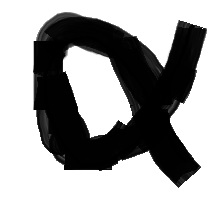

In [ ]:
img = Image.open("TEST/0.jpg")
roiOrig = cv2.imread("TEST/0.jpg")
roiOrig = cv2.cvtColor(roiOrig,cv2.COLOR_BGR2GRAY)

def add_border(image):
    pad = 10
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    print(pad, mask1.shape, mask2.shape)
    mask1 = np.uint8(np.ones((int(image.shape[0]), int(image.shape[1])))* 255.0)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res

# skip blank images   
area = img.size[0]*img.size[1]    
print(area)
print(cv2.countNonZero(roiOrig))
print(cv2.countNonZero(roiOrig) / area)
indices = np.argwhere(roiOrig == 0)

# Calculate the center of mass coordinates
center = np.mean(indices, axis=0)

print("Center of mass coordinates: ({}, {})".format(center[1], center[0]))

roiOrig = add_border(roiOrig)
# cv2.imshow("aa", roiOrig)
# cv2.waitKey(0)
if (cv2.countNonZero(roiOrig) / area < 0.99):         
#if (img.size[0]*img.size[1] - cv2.countNonZero(roiOrig) != 0):
    roi = cv2.resize(roiOrig, (224, 224))
    roi = cv2.dilate(roi, np.ones((3, 3), np.uint8), iterations=1)
    print('ok')
display(img)
img.close()

EVALUATION


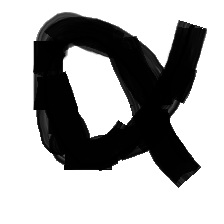

tensor(2.1866, device='cuda:0', grad_fn=<MaxBackward1>) 31
omega
tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]],
       device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)



In [ ]:
import cv2
from PIL import Image, ImageOps



model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

output =  cv2.imread("TEST/0.jpg")
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
#gray = cv2.blur(gray, (3, 3))
#_, gray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = 90
#gray = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,5)
#ret,thresh_img = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#gray = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)

#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(1),
    # transforms.ToTensor()

])        
x_image = convert_tensor(Image.fromarray(gray))
#x_image = add_contrast(x_image, 5)
to_tensor = transforms.ToTensor()

x_image = to_tensor(x_image)
aaa = transforms.ToPILImage()
display(aaa(x_image))
#aaa(x_image).save('a.jpg')

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image)
print(pred.max(), pred.argmax().item())
print(printer.char(pred.argmax().item()))
print(pred * torch.from_numpy(np.zeros(len(mnt.classes))).to(device))
printer = PrettyPrinter()
#print(pred[0][15])
print()
